In [ ]:
# default_exp data_vis

In [ ]:
# hide
from nbdev.showdoc import *

# data_vis

> Classes and functions enabling miscellaneous relevant data visualization tasks

In [ ]:
# export
import numpy as np
import scipy.interpolate
import matplotlib.pyplot as plt

In [ ]:
# export
plt_settings = {'axes.labelsize': 32,
                'xtick.major.size': 10,
                'xtick.major.width': 1.5,
                'xtick.labelsize': 24,
                'ytick.major.size': 10,
                'ytick.major.width': 1.5,
                'ytick.labelsize': 24,
                'legend.fontsize': 18,
                'lines.linewidth': 4,
                'lines.markersize': 10,
                'figure.figsize': (12,8)}

In [ ]:
# export
class cross_section_helper:
    """
    Class enabling computations and visualizations relating to signal and background cross sections
    """
    
    def __init__(self, masses, sig_css, bg_css, mass_units='GeV'):
        self.masses = masses
        self.sig_css = sig_css
        self.bg_css = bg_css
        self.mass_units = mass_units
        self.log_sig_css = np.log10(self.sig_css)
        self.m2logcsF = scipy.interpolate.interp1d(self.masses, self.log_sig_css, kind='cubic')
        self.logcs2mF = scipy.interpolate.interp1d(self.m2logcsF(self.masses), self.masses, kind='cubic')
        # WHERE TO PUT THIS VARIABLE?
        self.conv = 10**15 / 10**12 # cross sec (pb) * lumi (fb^{-1}) * self.conv = number of events
        
    def sig_cs(self, masses, who='E'):
        r"""
        Given a mass, returns the signal cross section (in pb) through interpolation
        """
        return np.power(10, self.m2logcsF(masses))
    
    def mass(self, css, who='E'):
        r"""
        Given a cross section, returns the particle mass value yielding that signal cross section 
        """
        return self.logcs2mF(np.log10(css))
    
    def absolute_max_mass_sens(self, lumi=3000, sig=5):
        return self.mass(sig**2 / (lumi * self.conv))

    def max_mass_sens_versus_tpr_fpr(self, plot=True, sig=5, lumi=3000, tpr_bounds=(0.1,1), fpr_bounds=(10**-7, 0.5), res=1000, 
                                     cvalues=None, clabels=None, manual=None):
        """
        For fixed luminosity and desired signal significance, plot the maximum mass sensitivity as a function of a
        binary classifier's true positive rate and false positive rate.
        """
        tprs = np.linspace(tpr_bounds[0], tpr_bounds[1], 100)
        fprs = np.sort(np.logspace(np.log10(fpr_bounds[0]), np.log10(fpr_bounds[1]), num=100, base=10))
        bg_yield = self.conv * np.sum(self.bg_css) * lumi
        coefsss = [
            [[-(self.conv * tpr * lumi)**2, sig**2 * self.conv * tpr * lumi, sig**2 * fpr * bg_yield] for fpr in fprs] for tpr in tprs]
        sig_csss = [[np.amax(np.roots(coefs)) for coefs in coefss] for coefss in coefsss]
        max_mass_senss = self.mass(sig_csss)
        
        # have found this plot works best when plotting log(fpr) on y-axis
        log_fprs = np.log10(fprs)
        ext = [tprs[0], tprs[-1], log_fprs[0], log_fprs[-1]]
        pts = np.array([[tpr,log_fpr] for tpr in tprs for log_fpr in log_fprs])
        data = max_mass_senss.flatten()
        grid = np.array(
                [[[x,y] for x in np.linspace(ext[0], ext[1], res)]
                for y in np.linspace(ext[2], ext[3], res)])
        interp = scipy.interpolate.griddata(pts, data, grid)

        if plot:  
            with plt.rc_context(plt_settings):
                plt.imshow(interp, origin='lower', aspect='auto', extent=ext, cmap='winter')
                cbar = plt.colorbar()
                plt.xlabel(r'{}'.format('True Positive Rate'))
                plt.ylabel(r'{}'.format('False Postive Rate'))
                cbar.set_label(r'{}'.format(f"Mass Sensitivity ({self.mass_units})"), rotation=90)
                if None not in [cvalues, clabels]:
                    result = plt.contour(grid[:,:,0], grid[:,:,1], interp, cvalues, colors='white',
                                                 linewidths=3, linestyles='dashed')
                    fmt = {lev:lab for lev, lab in zip(result.levels, clabels)}
                    plt.clabel(result, result.levels, inline=True, fmt=fmt, fontsize=32, manual=manual)
                minytick, maxytick = [int(log_fprs[0]) + 1, int(log_fprs[-1]) - 1]
                plt.yticks(
                    [i for i in range(minytick, maxytick+1)], [r'$10^{' + f'{i}' + r'}$' for i in range(minytick, maxytick+1)])
                
        return [grid, interp]

In [ ]:
show_doc(cross_section_helper.sig_cs)

<h4 id="cross_section_helper.sig_cs" class="doc_header"><code>cross_section_helper.sig_cs</code><a href="__main__.py#L18" class="source_link" style="float:right">[source]</a></h4>

> <code>cross_section_helper.sig_cs</code>(**`masses`**, **`who`**=*`'E'`*)

Given a mass, returns the signal cross section (in pb) through interpolation

In [ ]:
show_doc(cross_section_helper.mass)

<h4 id="cross_section_helper.mass" class="doc_header"><code>cross_section_helper.mass</code><a href="__main__.py#L24" class="source_link" style="float:right">[source]</a></h4>

> <code>cross_section_helper.mass</code>(**`css`**, **`who`**=*`'E'`*)

Given a cross section, returns the particle mass value yielding that signal cross section 

In [ ]:
masses, sig_css, bg_css = get_elijah_ttbarzp_cs()
elijah_ttbarzp = cross_section_helper(masses, sig_css, bg_css)

In [ ]:
print(np.round(elijah_ttbarzp.absolute_max_mass_sens(),3), elijah_ttbarzp.mass_units)

2363.088 GeV


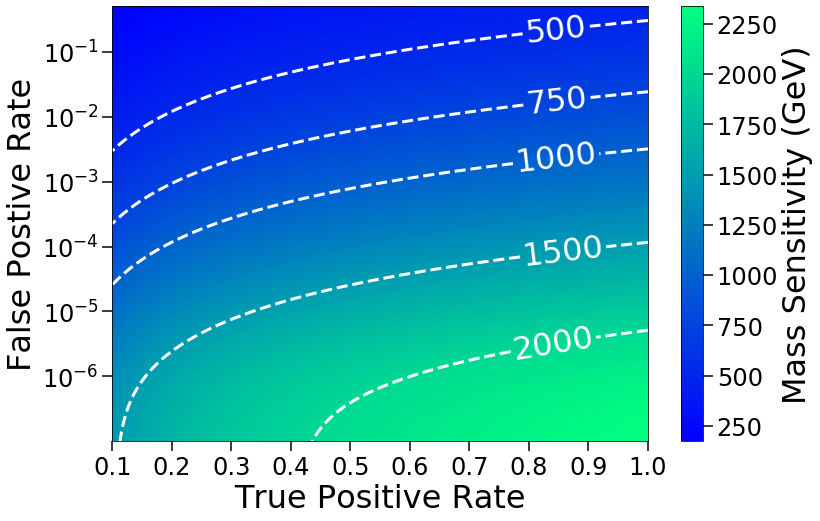

In [ ]:
cvalues = [500, 750, 1000, 1500, 2000]
clabels = [str(val) for val in cvalues]
manual = [(0.85, -1), (0.85, -2), (0.85, -3), (0.85, -3.5), (0.85, -6)]
elijah_ttbarzp.max_mass_sens_versus_tpr_fpr(plot=True, cvalues=cvalues, clabels=clabels, manual=manual);